# Reinforcement Learning

## Social DriveNet: Integrating DDQN with Social Attention for Autonomous Traffic Navigation



## Problem Definition

This research initiative aims to advance the domain of autonomous vehicle navigation within the [HighwayEnv](https://highway-env.farama.org/) simulation environment, focusing particularly on the integration of social dynamics in decision-making. Drawing from the foundational ideas presented in ["Social Attention for Autonomous Decision-Making in Dense Traffic"](https://arxiv.org/abs/1911.12250), this project introduces an extended approach by employing a Double Deep Q-Network (DDQN) with social attention mechanisms. This hybrid model is anticipated to outperform conventional reinforcement learning (RL) models, as it combines the robust policy optimization capabilities of DDQN with the nuanced perception of inter-vehicle dynamics provided by social attention.

### Project Objectives
The primary objective of this project is to develop and evaluate an RL agent capable of efficiently navigating complex traffic scenarios, employing both advanced decision-making architectures and traditional RL techniques. Key goals include:
- **Developing a Hybrid DDQN Model**: Integrating social attention mechanisms within a DDQN framework to enhance the agent’s responsiveness to dynamic traffic conditions.
- **Benchmarking Performance**: Comparing the developed model against established benchmarks from the [Stable Baselines3](https://github.com/DLR-RM/stable-baselines3) library to quantify improvements and establish performance baselines.
- **Optimizing for Practical Traffic Navigation**: Focusing on realistic driving maneuvers such as lane changing, speed adjustment, and adherence to traffic rules within a simulated multi-lane highway environment.

### Environment Description
**HighwayEnv** provides a complex, variable simulation environment where autonomous vehicles are tasked with navigating dense traffic. The environment is designed to simulate a range of traffic conditions from light to heavy, offering a robust platform for testing and enhancing the agent’s adaptive strategies.

#### Advanced State and Action Spaces
- **State Space Enhancements**: Includes detailed metrics such as the positional and velocity data of surrounding vehicles and the agent itself, crucial for the agent’s strategic planning and execution.
- **Action Space Extensions**: Comprises sophisticated maneuvers like strategic lane changes, acceleration, deceleration, and maintaining current vehicular states to navigate safely and efficiently through traffic.

#### Transition Dynamics and Reward Function
The transition dynamics incorporate the physical laws of motion and the behavioral patterns of simulated traffic, providing a realistic driving experience. The reward function is meticulously designed to promote operational efficiency, safety, and compliance with traffic regulations, encouraging the agent to make decisions that balance speed and safety, comfort, and lane discipline.

### Research Hypothesis
The project hypothesizes that a DDQN integrated with a social attention mechanism will significantly outperform traditional RL agents by adapting more effectively to varying traffic densities and complexities. This hypothesis will be tested through extensive simulations, evaluating the agent’s performance in terms of safety, efficiency, and compliance with traffic norms.


By merging DDQN with social attention, this project not only aims to address the limitations of current autonomous navigation systems but also explores the potential for these systems to understand and react to complex social interactions in traffic. The outcomes of this research could lead to significant improvements in the safety and efficiency of autonomous vehicles, paving the way for more advanced autonomous driving technologies.


## Background

### Reinforcement Learning in Autonomous Systems
Reinforcement Learning (RL) is a pivotal component of modern autonomous systems, offering a framework where agents learn optimal behaviors through interactions with an environment. In autonomous driving, RL is instrumental for developing systems that can make real-time decisions in unpredictable conditions. Traditional approaches, like Q-learning and its variants, have been foundational in teaching agents to navigate complex environments by learning to associate actions with rewards.

### Deep Q-Networks (DQN) and Its Variants
Introduced by Mnih et al. (2015), **Deep Q-Networks (DQN)** marked a significant advancement in applying RL to high-dimensional state spaces. DQN utilizes deep neural networks to approximate the action-value function, which effectively handles the complexities of environments analogous to real-world scenarios, including driving simulations. Formally, the DQN is defined as:

$$
Q^{new}(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[r_t + \gamma \max_{a}Q(s_{t+1}, a) - Q(s_t, a_t)\right]
$$

However, DQN can overestimate action values due to its max operator. This issue was addressed by **Double Deep Q-Networks (DDQN)**, which decouples the action selection from value computation, reducing overestimations and improving learning stability.

### Policy Gradient Methods: PPO and TRPO
Policy gradient methods, particularly **Proximal Policy Optimization (PPO)** and **Trust Region Policy Optimization (TRPO)**, optimize policy directly and are known for their effectiveness in environments requiring fine-grained control over continuous action spaces. PPO and TRPO enhance learning stability by employing strategies that limit the size of policy updates, thus preventing drastic changes that could lead to performance degradation.

### Integration of Social Attention Mechanisms
The concept of social attention in autonomous driving was explored thoroughly in the context of dense traffic by Leurent et al. (2019). The study proposed an architecture that integrates attention mechanisms to model the dependencies and interactions among multiple agents. The attention mechanism adjusts the influence of surrounding vehicles based on their relative importance, which is dynamically computed as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

This model allows for a nuanced understanding of the environment, enabling the agent to focus on the most relevant aspects of the scene to make more informed decisions.

### Current Project: Advancing DDQN with Social Attention
Building on these methodologies, this project aims to expand the robust optimization capabilities of DDQN with the dynamic, context-aware insights provided by social attention mechanisms. This hybrid approach is designed to significantly enhance the agent's performance in the HighwayEnv simulation, particularly in scenarios characterized by dense and complex traffic patterns. The integration seeks not only to optimize the tactical maneuvers of the vehicle but also to incorporate a strategic layer of interaction awareness, which is critical in real-world driving scenarios.

The integration of deep learning, reinforcement learning, and attention mechanisms represents the forefront of research in autonomous vehicle navigation. By combining these techniques, this project aspires to address some of the critical challenges in the field, such as decision-making in dense traffic and interaction with multiple agents, pushing the boundaries of what autonomous systems can achieve.

## Method

### Setting seeds for reproducibility

In [2]:
import random

import numpy as np
import torch

# Set seeds for reproducibility 
MANUAL_SEED = 1
random.seed(MANUAL_SEED)
np.random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)

### Setting Up the Highway Environment

The highway-env environment introduces an exciting domain focused on autonomous driving and decision-making in traffic scenarios. This environment is designed for experimenting with various aspects of vehicle behavior, such as lane following, overtaking, and navigating through intersections, making it rich in learning opportunities for reinforcement learning applications.

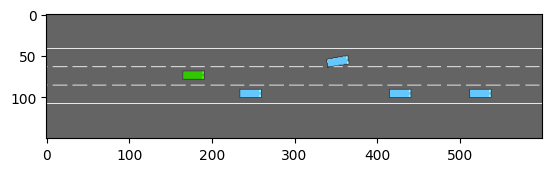

In [10]:
%matplotlib inline

import gymnasium as gym
from matplotlib import pyplot as plt

highway_env = gym.make('highway-fast-v0', render_mode="rgb_array")
env_config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
        "features": ["presence", "x", "y", "vx", "vy"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False
    }
}
highway_env.unwrapped.config["vehicles_density"] = 1.3
highway_env.unwrapped.configure(env_config)
highway_env.reset()

# To visualise a initial/idle state
action = highway_env.unwrapped.action_type.actions_indexes["IDLE"]
obs, reward, done, truncated, info = highway_env.step(action)

plt.imshow(highway_env.render())
plt.show()

highway_env.close()


### Exploring the Highway Environment

Exploring and understanding the environment by analysing the observation and action spaces, the dynamics of the environment, and the reward structure. Here’s how you can start exploring highway-env:

#### Understanding the Observation Space:

The observation space in highway-env can vary based on the configuration but typically includes the positions, velocities, and other attributes of nearby vehicles relative to the controlled vehicle. Understanding this space is crucial for designing your agent:

In [3]:
print("Observation space:", highway_env.observation_space)

Observation space: Box(-inf, inf, (15, 5), float32)


#### Understanding the Action Space:
Actions in highway-env usually involve discrete decisions like changing lanes, accelerating, or braking:

In [4]:
print("Action space:", highway_env.action_space)

Action space: Discrete(5)


#### Reward Structure Exploration

Understanding how rewards are assigned is crucial for designing your RL model. Perform actions and progress through the game to see what actions increase the score, how much reward is given for different achievements, and identify if there are any penalties.

In [5]:
# Example: Perform an action and observe the reward
highway_env.reset()
for _ in range(50):
    _, reward, _, _, _ = highway_env.step(highway_env.action_space.sample())
    print("Reward received: ", reward)


Reward received:  0.8333333333333334
Reward received:  0.7175582990397805
Reward received:  0.8180872382823305
Reward received:  0.7973808981448038
Reward received:  0.9155103193105965
Reward received:  0.8152112781447386
Reward received:  0.0
Reward received:  0.0
Reward received:  0.03333333333333336
Reward received:  0.03333333333333336
Reward received:  0.03333333333333336
Reward received:  0.03333333333333336
Reward received:  0.03333333333333336
Reward received:  0.03333333333333336
Reward received:  0.03333333333333336
Reward received:  0.03333333333333336
Reward received:  0.03333333333333336
Reward received:  0.03333333333333336
Reward received:  0.0
Reward received:  0.03333333333333336
Reward received:  0.03333333333333336
Reward received:  0.0
Reward received:  0.0
Reward received:  0.0
Reward received:  0.0
Reward received:  0.0
Reward received:  0.0
Reward received:  0.0
Reward received:  0.0
Reward received:  0.0
Reward received:  0.0
Reward received:  0.0333333333333333

#### Visualizing the Environment - Simulation:

You can visualize the environment in a Jupyter notebook or Python script to understand the dynamics visually. highway-env supports rendering directly to a Jupyter notebook using its render method.

In [3]:
import imageio
from IPython.display import Image, display

def generate_gif(frames):
    # Save the captured frames as a GIF
    gif_path = 'highway_simulation.gif'
    imageio.mimsave(gif_path, frames, fps=10)  # fps controls the speed of the animation

    # Display the GIF in the notebook
    display(Image(filename=gif_path))


Simple environment demonstration:

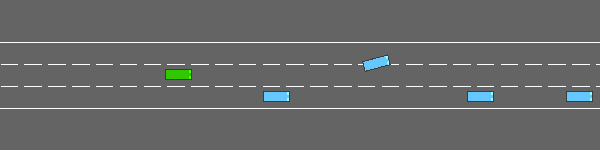

In [4]:
# reset environment
highway_env.reset()

frames = []  # for storing the frames captured during the simulation

# Simulate the environment
for _ in range(50):
    action = highway_env.action_space.sample()  # choose a random action
    obs, reward, terminated, truncated, info = highway_env.step(action)
    frames.append(highway_env.render())
    done = terminated or truncated
    if done:
        highway_env.reset()

# Close the environment to free resources
highway_env.close()

generate_gif(frames)

#### Defining the objective:

The agent's object is straighforward: maximize average speed while minimizing collisions, with an additional goal of staying in the right lane as much as possible for extra reward. These objectives align well with the rewards settings described (collision_reward, high_speed_reward, and implicitly mentioning a right_lane_reward). This clarity will guide the design of your reinforcement learning model and the reward structure you implement.

## Baseline Performance with Stable Baselines3

Stable Baselines3 is a set of reliable implementations of reinforcement learning algorithms in PyTorch. It is the next major version of Stable Baselines.

### Model Training

Reinforcement Learning agents can be trained using libraries such as eleurent/rl-agents, openai/baselines or Stable Baselines3. In the next cell, a SB3 DQN is trained on highway-fast-v0 with its default kinematics observation and an MLP model. The hyperparameters come from the [documentation](https://highway-env.farama.org/quickstart/#training-an-agent) and, for a first training, the default values are used. Further tuning is performed next in this notebook.

Before the fine-tuning process, the chosen hyperparameters for the DQN model were set with a mix of default values and some tailored adjustments expected to work well for a range of problems:

- `net_arch=[256, 256]`: This specifies a neural network architecture with two hidden layers, each consisting of 256 neurons. This relatively large network architecture is chosen with the expectation that it can capture the complexity of the state space and learn effective policies.

- `learning_rate=5e-4`: The learning rate determines the step size at each iteration while moving toward a minimum of the loss function. A rate of 0.0005 is a common starting point that is not too large to overshoot minima nor too small to slow the convergence.

- `buffer_size=15000`: This is the size of the replay buffer. A larger buffer size allows the agent to learn from a broader set of experiences, potentially smoothing out the learning process and avoiding overfitting to recent experiences.

- `learning_starts=200`: This parameter determines how many steps of the model are run before the learning process begins. This warm-up period allows the replay buffer to fill with experiences, ensuring that learning does not begin with a poor understanding of the environment.

- `batch_size=32`: This sets the number of experiences to sample from the buffer to update the network at each learning step. A batch size of 32 is a standard choice that balances the variance and convergence rate.

- `gamma=0.8`: The discount factor, gamma, balances immediate and future rewards. A value of 0.8 suggests that future rewards are taken into consideration significantly, but with a preference for more immediate rewards.

- `train_freq=1`: This sets the frequency of training the network. Here, the network is trained at every step.

- `gradient_steps=1`: This is the number of gradient steps taken for each training step. Since this is set to 1, it means that a single optimization step is taken for each training step.

- `target_update_interval=50`: This parameter sets how often the target network is updated. The target network stabilizes training by providing a fixed snapshot of the policy for a period of time. An interval of 50 is a balance between stability and responsiveness to changes in the policy.

- `verbose=1`: This sets the verbosity level to output detailed logs during training.

- `tensorboard_log="highway_dqn_baseline/tensorboard_logs"`: This argument points to the directory where TensorBoard logs should be saved, enabling visualization of the training process.

These hyperparameters were chosen to provide a balance between exploration and exploitation, learning efficiency, and computational resources. They are often selected based on empirical results from similar environments or as a starting point for further refinement through fine-tuning or hyperparameter optimization.

In [8]:
from stable_baselines3 import DQN

model = DQN('MlpPolicy', highway_env,
              policy_kwargs=dict(net_arch=[256, 256]),
              learning_rate=5e-4,
              buffer_size=15000,
              learning_starts=200,
              batch_size=32,
              gamma=0.8,
              train_freq=1,
              gradient_steps=1,
              target_update_interval=50,
              verbose=1,
              tensorboard_log="logs/highway_dqn_baseline")
model.learn(int(2e4))
model.save("models/highway_dqn_baseline/model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/highway_dqn_baseline/DQN_8
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.25     |
|    ep_rew_mean      | 5.82     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 66       |
|    time_elapsed     | 0        |
|    total_timesteps  | 33       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 7.12     |
|    ep_rew_mean      | 5.1      |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 67       |
|    time_elapsed     | 0        |
|    total_timesteps  | 57       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      |

### Model Evaluation

In [12]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

%tensorboard --logdir ./logs/highway_dqn_baseline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 81074), started 3:15:57 ago. (Use '!kill 81074' to kill it.)

The TensorBoard graphs display the performance of eight separate training runs of a baseline model using a Deep Q-Network (DQN) algorithm. The plots show three different metrics: episode length mean, episode reward mean, and frames per second (fps), which can be indicative of training efficiency.

From the first graph, the mean episode length for both runs increases over time, suggesting that the agent is learning to sustain longer episodes through its interactions with the environment. Both runs appear to converge towards similar performance, with DQN_6 showing a slightly higher mean episode length. The second graph shows the mean episode reward increasing over time, indicating that the agent is learning to maximize rewards. Similar to episode length, both runs show converging trends, with DQN_6 outperforming the other iterations by the end of the training.

The third graph displays the fps, which remain relatively consistent throughout training for all runs, with minor initial fluctuations. The fps measure how quickly the model is processing frames, and it seems to stabilize quickly, implying a steady computational performance.

#### Baseline Model Prediction - Creating frames from each episode

In [5]:
from stable_baselines3 import DQN

model = DQN.load("models/highway_dqn_baseline/model")


def evaluate_model(env, model, num_episodes=100):
    frames = []  # Store frames for each episode
    for episode in range(num_episodes):
        done = truncated = False
        obs, _ = env.reset()
        total_reward = 0
        steps = 0
        
        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, _ = env.step(action)
            frame = env.render()
            frames.append(frame)
            total_reward += reward
            steps += 1
        
        print(f"Episode {episode + 1}: Total Reward = {total_reward}, Steps = {steps}")

    env.close()

    return frames

highway_dqn_baseline_frames = evaluate_model(highway_env, model)

/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(


Episode 1: Total Reward = 6.999377276124431, Steps = 9
Episode 2: Total Reward = 1.9327106094585282, Steps = 3
Episode 3: Total Reward = 13.518931450989971, Steps = 19
Episode 4: Total Reward = 8.553554502128845, Steps = 12
Episode 5: Total Reward = 20.63204969637204, Steps = 28
Episode 6: Total Reward = 4.066316801460215, Steps = 5
Episode 7: Total Reward = 16.545822018926934, Steps = 21
Episode 8: Total Reward = 19.13271060945777, Steps = 23
Episode 9: Total Reward = 12.199377276124434, Steps = 15
Episode 10: Total Reward = 2.666666666666667, Steps = 4
Episode 11: Total Reward = 13.345156598395338, Steps = 15
Episode 12: Total Reward = 9.15293177767612, Steps = 13
Episode 13: Total Reward = 0.9333333333333333, Steps = 2
Episode 14: Total Reward = 0.9333333333333333, Steps = 2
Episode 15: Total Reward = 3.532710609457764, Steps = 5
Episode 16: Total Reward = 22.95355450236549, Steps = 30
Episode 17: Total Reward = 8.918980694112289, Steps = 12
Episode 18: Total Reward = 14.46666746746

### Baseline model - Test Visual Inspection


In [6]:
from IPython.display import Video
from moviepy.editor import ImageSequenceClip

# Specify the frame rate (frames per second)
fps = 20.0

# Create a video clip from the frames
clip = ImageSequenceClip(highway_dqn_baseline_frames, fps=fps)
clip.write_videofile('videos/highway_baseline_performance.mp4', fps=fps, codec='libx264')

Video("videos/highway_baseline_performance.mp4")

Moviepy - Building video videos/highway_baseline_performance.mp4.
Moviepy - Writing video videos/highway_baseline_performance.mp4



Moviepy - Done !
Moviepy - video ready videos/highway_baseline_performance.mp4


### Baseline model - Hyperparameter fine tuning

The fine-tuning process for the DQN model is conducted using Bayesian optimization via Optuna, which methodically searched for the optimal combination of hyperparameters within defined ranges. This approach systematically adjusts and evaluates the hyperparameters to maximize the expected outcome—here, the mean reward from the policy evaluation. The parameters explored include learning rate, batch size, gamma (discount factor), and network architecture.

The fine-tuning focus on expanding the search space for gamma and altering the network architecture options. The learning rate was adjusted to lie between 1e-5 and 1e-3, and batch size variants were considered at 32, 64, and 128. The discount factor gamma's range was broadened from 0.8-0.99 in the baseline to 0.5-0.99 in the fine-tuning, allowing more exploration of the agent's long-term reward expectations. Network architecture choices were among single-layer [128], dual-layer [256, 256], and triple-layer [128, 128, 128].

In [7]:
import optuna
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy


def optimize_agent(trial):
    # Define hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    gamma = trial.suggest_uniform('gamma', 0.5, 0.99)
    net_arch = trial.suggest_categorical('net_arch', [[128], [256, 256], [128, 128, 128]])

    # Create the model with these hyperparameters
    model = DQN('MlpPolicy', highway_env,
                policy_kwargs=dict(net_arch=net_arch),
                learning_rate=learning_rate,
                buffer_size=15000,
                learning_starts=200,
                batch_size=batch_size,
                gamma=gamma,
                train_freq=1,
                gradient_steps=1,
                target_update_interval=50,
                verbose=0,
                tensorboard_log="./logs/highway_dqn_optuna")

    # Train the model
    model.learn(int(2e4))
    
    # Evaluate the model, here using mean reward
    mean_reward, _ = evaluate_policy(model.policy, highway_env, n_eval_episodes=50)
    
    # Clear memory
    model.save(f"models/highway_dqn_optuna/optuna_dqn_{trial.number}")
    model.env.close()
    del model

    return mean_reward

study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent, n_trials=20, n_jobs=-1)

print('Best hyperparameters: ', study.best_trial.params)

[I 2024-04-28 11:08:54,114] A new study created in memory with name: no-name-a0ef266a-9ddd-488a-8041-c85405b203d0
[I 2024-04-28 11:15:38,145] Trial 0 finished with value: 17.769810685515402 and parameters: {'learning_rate': 0.0004574287393447737, 'batch_size': 32, 'gamma': 0.7454706549806513, 'net_arch': [128, 128, 128]}. Best is trial 0 with value: 17.769810685515402.
[I 2024-04-28 11:22:12,522] Trial 1 finished with value: 6.2574314734339715 and parameters: {'learning_rate': 6.358936829899646e-05, 'batch_size': 128, 'gamma': 0.6931848994544483, 'net_arch': [128]}. Best is trial 0 with value: 17.769810685515402.
[I 2024-04-28 11:29:10,433] Trial 2 finished with value: 15.415484842322767 and parameters: {'learning_rate': 0.0006084574687937738, 'batch_size': 64, 'gamma': 0.6260031433042827, 'net_arch': [128, 128, 128]}. Best is trial 0 with value: 17.769810685515402.
[I 2024-04-28 11:35:53,316] Trial 3 finished with value: 7.593011140531526 and parameters: {'learning_rate': 0.0002075473

Best hyperparameters:  {'learning_rate': 0.0004574287393447737, 'batch_size': 32, 'gamma': 0.7454706549806513, 'net_arch': [128, 128, 128]}


The fine-tuning efforts yielded a best set of hyperparameters with a learning rate of approximately 0.000457, batch size of 32, a gamma of 0.7454, and a network architecture of three 128-unit layers. 

#### Baseline model - Re-train after hyperparameter tuning

In [15]:
from stable_baselines3 import DQN

model = DQN('MlpPolicy', highway_env,
              policy_kwargs=dict(net_arch=[128, 128, 128]),
              learning_rate=0.000457,
              buffer_size=15000,
              learning_starts=200,
              batch_size=32,
              gamma=0.745,
              train_freq=1,
              gradient_steps=1,
              target_update_interval=50,
              verbose=1,
              tensorboard_log="./logs/highway_dqn_fine_tuned_baseline")
model.learn(int(2e4))
model.save("./models/highway_dqn_fine_tuned_baseline/model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/highway_dqn_fine_tuned_baseline/DQN_1


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.5      |
|    ep_rew_mean      | 3.89     |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 54       |
|    time_elapsed     | 0        |
|    total_timesteps  | 22       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.62     |
|    ep_rew_mean      | 3.9      |
|    exploration_rate | 0.979    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 55       |
|    time_elapsed     | 0        |
|    total_timesteps  | 45       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.25     |
|    ep_rew_mean      | 3.66     |
|    exploration_rate | 0.97     |
| time/               |          |
|    episodes       

### Model Evaluation - After tuning

In [16]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

%tensorboard --logdir ./logs/highway_dqn_fine_tuned_baseline

Reusing TensorBoard on port 6007 (pid 4090), started 0:19:23 ago. (Use '!kill 4090' to kill it.)

When comparing these fine-tuned results to the previous baseline model, the adjustments in hyperparameters appear to have led to a more proficient agent. The exploration rate's decline suggests that as training progressed, the agent became more confident in its strategy and less reliant on exploration. This balance between exploration and exploitation is crucial for the agent's performance, as evidenced by the improved mean reward and episode length. The adjustment in network architecture may have contributed significantly to these improvements by providing more robust updates during learning, as well as a network capacity more suited to the complexity of the task.

### Fine-tuned Baseline model - Test Visual Inspection


In [17]:
from IPython.display import Video
from moviepy.editor import ImageSequenceClip

model = DQN.load("./models/highway_dqn_fine_tuned_baseline/model")
highway_dqn_fine_tuned_baseline_frames = evaluate_model(highway_env, model)

# Specify the frame rate (frames per second)
fps = 20

# Create a video clip from the frames
clip = ImageSequenceClip(highway_dqn_baseline_frames, fps=fps)
clip.write_videofile('./videos/highway_fine_tuned_baseline_performance.mp4', fps=fps, codec='libx264')

Video("./videos/highway_fine_tuned_baseline_performance.mp4")

Episode 1: Total Reward = 6.5131121781841195, Steps = 8
Episode 2: Total Reward = 23.086887835702996, Steps = 30
Episode 3: Total Reward = 10.886880953817162, Steps = 13
Episode 4: Total Reward = 8.101422374612948, Steps = 11
Episode 5: Total Reward = 0.9157750342935529, Steps = 2
Episode 6: Total Reward = 1.9151527517185956, Steps = 3
Episode 7: Total Reward = 5.079282923384422, Steps = 7
Episode 8: Total Reward = 25.918853273989395, Steps = 30
Episode 9: Total Reward = 5.796715648225837, Steps = 7
Episode 10: Total Reward = 11.353554502369182, Steps = 16
Episode 11: Total Reward = 10.179156548416445, Steps = 11
Episode 12: Total Reward = 5.01756357932352, Steps = 7
Episode 13: Total Reward = 3.0464515787153963, Steps = 4
Episode 14: Total Reward = 2.8864435592844675, Steps = 4
Episode 15: Total Reward = 11.582740107643298, Steps = 14
Episode 16: Total Reward = 5.179157349186058, Steps = 6
Episode 17: Total Reward = 5.197337235458764, Steps = 6
Episode 18: Total Reward = 1.18012949697

Moviepy - Done !
Moviepy - video ready ./videos/highway_fine_tuned_baseline_performance.mp4


### Custom DDQN Model - Training


#### Hyperparameter tuning

In [3]:
import sys
sys.path.append('../src') # to make ddqn_attention module accessible.

import optuna

from ddqn_attention import training_helpers
from ddqn_attention.ddqn import DDQN
from ddqn_attention.buffer import ReplayBuffer


def objective(trial):
    action_dim = 5
    buffer_size = 30000
    num_episodes = 1000
    minimal_size = 150

    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    gamma = trial.suggest_float('gamma', 0.5, 0.99, log=True)
    epsilon = trial.suggest_categorical('epsilon', [0.8, 0.9, 0.95, 0.99])
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    target_update = trial.suggest_categorical('target_update', [60, 80, 100])
    hidden_dim = trial.suggest_categorical('hidden_dim', [[128, 128], [256, 256]])

    agent = DDQN(action_dim, hidden_dim, learning_rate, gamma, epsilon, target_update)
    replay_buffer = ReplayBuffer(buffer_size)
    return_list = training_helpers.train_agent(highway_env, agent, num_episodes, replay_buffer, minimal_size, batch_size)
    
    final_return = np.mean(return_list)
    return final_return

highway_env.reset()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, n_jobs=1)

print("Best hyperparameters:", study.best_trial.params)


[I 2024-04-28 17:45:57,031] A new study created in memory with name: no-name-04e05fb8-b1da-4391-9259-011ed1016c50


/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)


Starting training: 1000 episodes


Total Progress: 100%|██████████| 1000/1000 [03:45<00:00,  4.44it/s, episode=1000, mean_reward=61.921]
[I 2024-04-28 17:49:42,599] Trial 0 finished with value: 57.488580357892644 and parameters: {'learning_rate': 2.936401042271753e-05, 'gamma': 0.9228386369719526, 'epsilon': 0.99, 'batch_size': 64, 'target_update': 60, 'hidden_dim': [128, 128]}. Best is trial 0 with value: 57.488580357892644.
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but

Training complete.
Starting training: 1000 episodes


Total Progress: 100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s, episode=1000, mean_reward=129.901]
[I 2024-04-28 17:59:23,758] Trial 1 finished with value: 86.31994525237235 and parameters: {'learning_rate': 0.00010091608515314163, 'gamma': 0.987583650865616, 'epsilon': 0.8, 'batch_size': 256, 'target_update': 80, 'hidden_dim': [128, 128]}. Best is trial 1 with value: 86.31994525237235.
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but 

Training complete.
Starting training: 1000 episodes


Total Progress: 100%|██████████| 1000/1000 [03:27<00:00,  4.81it/s, episode=1000, mean_reward=47.884]
[I 2024-04-28 18:02:51,734] Trial 2 finished with value: 52.58979917762332 and parameters: {'learning_rate': 0.00010919403410181862, 'gamma': 0.7697809680215988, 'epsilon': 0.8, 'batch_size': 64, 'target_update': 60, 'hidden_dim': [128, 128]}. Best is trial 1 with value: 86.31994525237235.
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but c

Training complete.
Starting training: 1000 episodes


Total Progress: 100%|██████████| 1000/1000 [05:05<00:00,  3.27it/s, episode=1000, mean_reward=85.696]
[I 2024-04-28 18:07:57,544] Trial 3 finished with value: 75.41960322536484 and parameters: {'learning_rate': 0.002706772033124282, 'gamma': 0.6091381972494104, 'epsilon': 0.95, 'batch_size': 64, 'target_update': 80, 'hidden_dim': [128, 128]}. Best is trial 1 with value: 86.31994525237235.
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but co

Training complete.
Starting training: 1000 episodes


Total Progress: 100%|██████████| 1000/1000 [04:31<00:00,  3.68it/s, episode=1000, mean_reward=37.852]
[I 2024-04-28 18:12:29,320] Trial 4 finished with value: 42.65585449251489 and parameters: {'learning_rate': 2.753712534015828e-05, 'gamma': 0.5801750833391581, 'epsilon': 0.9, 'batch_size': 256, 'target_update': 60, 'hidden_dim': [128, 128]}. Best is trial 1 with value: 86.31994525237235.
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but c

Training complete.
Starting training: 1000 episodes


Total Progress: 100%|██████████| 1000/1000 [07:33<00:00,  2.20it/s, episode=1000, mean_reward=119.888]
[I 2024-04-28 18:20:02,848] Trial 5 finished with value: 89.25630337371939 and parameters: {'learning_rate': 0.002265898105933512, 'gamma': 0.7093581079384662, 'epsilon': 0.8, 'batch_size': 128, 'target_update': 100, 'hidden_dim': [256, 256]}. Best is trial 5 with value: 89.25630337371939.
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but 

Training complete.
Starting training: 1000 episodes


Total Progress: 100%|██████████| 1000/1000 [06:07<00:00,  2.72it/s, episode=1000, mean_reward=39.689]
[I 2024-04-28 18:26:10,709] Trial 6 finished with value: 56.654737417228745 and parameters: {'learning_rate': 1.3852396699085904e-05, 'gamma': 0.7452079007273384, 'epsilon': 0.8, 'batch_size': 256, 'target_update': 60, 'hidden_dim': [256, 256]}. Best is trial 5 with value: 89.25630337371939.
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but

Training complete.
Starting training: 1000 episodes


Total Progress: 100%|██████████| 1000/1000 [04:51<00:00,  3.42it/s, episode=1000, mean_reward=50.820]
[I 2024-04-28 18:31:02,689] Trial 7 finished with value: 61.614706884084946 and parameters: {'learning_rate': 3.709513122126441e-05, 'gamma': 0.5227301702247042, 'epsilon': 0.8, 'batch_size': 128, 'target_update': 80, 'hidden_dim': [256, 256]}. Best is trial 5 with value: 89.25630337371939.
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but 

Training complete.
Starting training: 1000 episodes


Total Progress: 100%|██████████| 1000/1000 [09:45<00:00,  1.71it/s, episode=1000, mean_reward=109.177]
[I 2024-04-28 18:40:48,634] Trial 8 finished with value: 87.0623766790211 and parameters: {'learning_rate': 0.0007575303364365402, 'gamma': 0.7896535088494814, 'epsilon': 0.95, 'batch_size': 256, 'target_update': 80, 'hidden_dim': [256, 256]}. Best is trial 5 with value: 89.25630337371939.
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but 

Training complete.
Starting training: 1000 episodes


Total Progress: 100%|██████████| 1000/1000 [06:23<00:00,  2.61it/s, episode=1000, mean_reward=89.463]
[I 2024-04-28 18:47:12,115] Trial 9 finished with value: 79.9434205412018 and parameters: {'learning_rate': 0.00019387051029882074, 'gamma': 0.9422778808070171, 'epsilon': 0.99, 'batch_size': 128, 'target_update': 80, 'hidden_dim': [128, 128]}. Best is trial 5 with value: 89.25630337371939.


Training complete.
Best hyperparameters: {'learning_rate': 0.002265898105933512, 'gamma': 0.7093581079384662, 'epsilon': 0.8, 'batch_size': 128, 'target_update': 100, 'hidden_dim': [256, 256]}


### Training with selected Hyperparameters

In [3]:
import os
import sys
sys.path.append('../src') # to make ddqn_attention module accessible.

from ddqn_attention import training_helpers
from ddqn_attention.ddqn import DDQN
from ddqn_attention.buffer import ReplayBuffer

highway_env.reset()
num_episodes = int(2e4)

# Hyperparameters
#Best hyperparameters: {
# 'learning_rate': 0.002265898105933512, 
#'gamma': 0.7093581079384662, 'epsilon': 0.8, 'batch_size': 128, 'target_update': 100, 'hidden_dim': [256, 256]}
lr = 0.002265
action_dim = 5
hidden_dim = [256, 256]
gamma = 0.70935
epsilon = 0.8
target_update = 100
buffer_size = 30000
minimal_size = 150
batch_size = 128

replay_buffer = ReplayBuffer(buffer_size)
agent = DDQN(action_dim, hidden_dim, lr, gamma, epsilon, target_update)
return_list = training_helpers.train_agent(highway_env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

torch.save(agent.state_dict(), "./models/highway_ddqn_attention/model.pt")

Starting training: 20000 episodes


Total Progress: 100%|██████████| 20000/20000 [3:52:40<00:00,  1.43it/s, episode=20000, mean_reward=183.661]  

Training complete.


### Custom model - Evaluation

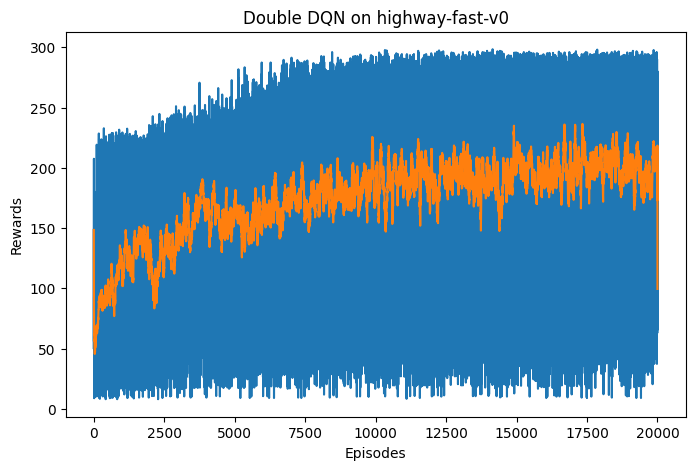

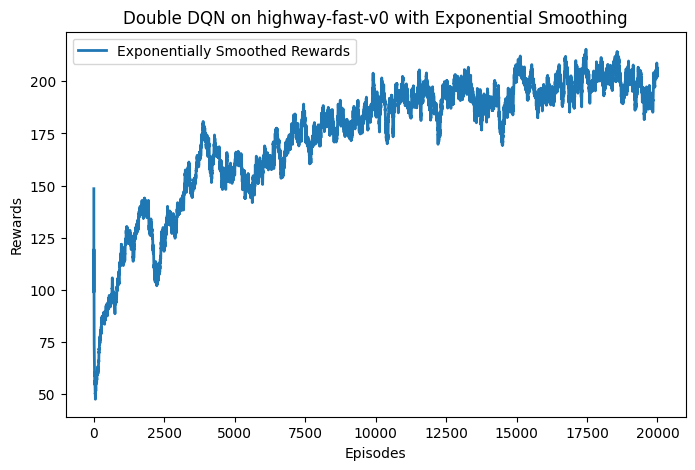

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

logs_dir = "./logs"

os.makedirs(logs_dir, exist_ok=True)

episodes_list = list(range(len(return_list)))
plt.figure(figsize=(8, 5))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Double DQN on {}'.format('highway-fast-v0'))
plt.savefig(f"{logs_dir}/highway_ddqn_attention/ddqn_returns.png")

mv_return = training_helpers.moving_average(return_list, 55)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Double DQN on highway-fast-v0')
plt.savefig(f"{logs_dir}/highway_ddqn_attention/ddqn_moving_avg.png")

returns_series = pd.Series(return_list)

# Apply exponential smoothing with a specific alpha
smoothed_returns = returns_series.ewm(alpha=0.01).mean()

plt.figure(figsize=(8, 5))
plt.plot(episodes_list, smoothed_returns, label='Exponentially Smoothed Rewards', linewidth=2)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Double DQN on highway-fast-v0 with Exponential Smoothing')
plt.legend()
plt.savefig(f"{logs_dir}/highway_ddqn_attention/ddqn_exponential_smoothing.png")
plt.show()


### DDQN model - Test Visual Inspection


In [4]:
import sys
sys.path.append('../src') # to make ddqn_attention module accessible.

from ddqn_attention.ddqn import DDQN

agent = DDQN()
agent.load_state_dict(torch.load("./models/highway_ddqn_attention/model.pt"))
agent.eval()

DDQN(
  (q_net): QValueNet(
    (attn): Attention(
      (q_proj): Linear(in_features=5, out_features=96, bias=True)
      (kv_proj): Linear(in_features=5, out_features=192, bias=True)
      (o_proj): Linear(in_features=96, out_features=96, bias=True)
    )
    (fc_layers): ModuleList(
      (0): Linear(in_features=96, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (fc_out): Linear(in_features=256, out_features=5, bias=True)
  )
  (target_q_net): QValueNet(
    (attn): Attention(
      (q_proj): Linear(in_features=5, out_features=96, bias=True)
      (kv_proj): Linear(in_features=5, out_features=192, bias=True)
      (o_proj): Linear(in_features=96, out_features=96, bias=True)
    )
    (fc_layers): ModuleList(
      (0): Linear(in_features=96, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (fc_out): Linear(in_features=256, out_features=5, bias=True)
  )
)

### Agent Evaluation

In [8]:
import gymnasium as gym

from IPython.display import Video
from moviepy.editor import ImageSequenceClip

# Reconfigure env with increased traffic to test agent
highway_env = gym.make('highway-fast-v0', render_mode="rgb_array")
env_config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 20, # increased traffic
        "features": ["presence", "x", "y", "vx", "vy"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False
    }
}
highway_env.unwrapped.config["duration"] = 200
highway_env.unwrapped.config["lanes_count"] = 3
highway_env.unwrapped.config["vehicles_density"] = 1.5
highway_env.unwrapped.configure(env_config)
highway_env.reset()

# Evaluate the agent and store the total reward per episode
def evaluate_agent(episodes, highway_env):
    episode_rewards = []
    episode_frames = {}
    for episode in range(episodes):
        obs, _ = highway_env.reset()
        done = truncated = False
        total_reward = 0
        frames = []
        while not (done or truncated):
            action = agent.take_action(obs)
            obs, reward, done, truncated, _ = highway_env.step(action)
            frame = highway_env.render()
            frames.append(frame)
            total_reward += reward
        episode_rewards.append(total_reward)
        episode_frames[episode] = frames
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    return episode_rewards, episode_frames

episodes = 100
episode_rewards, episode_frames = evaluate_agent(episodes, highway_env)
highway_env.close()

# Let's pick the top 10 episodes
best_episodes = np.argsort(episode_rewards)[-10:]  

# Combine frames of the best episodes for the video
best_frames = []
for episode in best_episodes:
    best_frames.extend(episode_frames[episode])

# Create and save the video
fps = 20
clip = ImageSequenceClip(best_frames, fps=fps)
clip.write_videofile('./videos/highway_ddqn_attention_best_episodes.mp4', fps=fps, codec='libx264')

Video("./videos/highway_ddqn_attention_best_episodes.mp4")

Episode 1: Total Reward = 42.832029340625255
Episode 2: Total Reward = 10.516334908224042
Episode 3: Total Reward = 2.632131297184751
Episode 4: Total Reward = 192.36969762802016
Episode 5: Total Reward = 12.032044432590826
Episode 6: Total Reward = 197.0035139808033
Episode 7: Total Reward = 6.278684929317572
Episode 8: Total Reward = 197.50227086105974
Episode 9: Total Reward = 16.086264339267142
Episode 10: Total Reward = 4.446029436808459
Episode 11: Total Reward = 195.80506041081122
Episode 12: Total Reward = 8.418703616588461
Episode 13: Total Reward = 6.96550475718132
Episode 14: Total Reward = 199.1727397845541
Episode 15: Total Reward = 11.650920750147451
Episode 16: Total Reward = 197.57107359841513
Episode 17: Total Reward = 4.829741973079916
Episode 18: Total Reward = 12.794937711615345
Episode 19: Total Reward = 3.746451578715396
Episode 20: Total Reward = 198.83893051085028
Episode 21: Total Reward = 4.912183267275223
Episode 22: Total Reward = 198.60629786199777
Episode 

Moviepy - Done !
Moviepy - video ready ./videos/highway_ddqn_attention_best_episodes.mp4


## References

Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G. & De Freitas, N. (2015). Human-level control through deep reinforcement learning. Nature, 518(7540), 529-533.

Oudeyer, P. Y., & Kaplan, F. (2007). Intrinsic motivation systems for autonomous mental development. IEEE Transactions on Evolutionary Computation, 11(1), 26-50.

Schaul, T., Hung, A., Pi-Chang, H., & Sutskever, I. (2015, December). Prioritized experience replay. In Advances in neural information processing systems (pp. 4662-4670).

Wang, Z., Schaul, T., Hessel, M., Van Hasselt, H., & Wierstra, D. (2016). Dueling network architectures for deep reinforcement learning. In International conference on machine learning (pp. 1994-2003).


- Mnih, V. et al. (2015). Human-level control through deep reinforcement learning. *Nature*, 518(7540), 529-533.
- Schulman, J., et al. (2015). Trust Region Policy Optimization. *International Conference on Machine Learning (ICML)*.
- Schulman, J., et al. (2017). Proximal Policy Optimization Algorithms. *arXiv preprint arXiv:1707.06347*.
- Dosovitskiy, A. et al. (2017). Learning to act by predicting the future. *International Conference on Learning Representations (ICLR)*.
- Liang, X., et al. (2018). Deep Reinforcement Learning for Autonomous Driving. *Machine Learning Systems Workshop at NeurIPS*.
